<a href="https://colab.research.google.com/github/Michaelnormantovich/Plant-disease-classifier/blob/main/Disease_calssifier_resnet_43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown

In [ ]:
import gdown
file_id = "1nQXTXV_Jfi2-sNBv7mpqo5AElCLu0TRS"  # Replace with your FILE_ID
gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", "archive.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1nQXTXV_Jfi2-sNBv7mpqo5AElCLu0TRS
From (redirected): https://drive.google.com/uc?export=download&id=1nQXTXV_Jfi2-sNBv7mpqo5AElCLu0TRS&confirm=t&uuid=befaecb9-e627-4122-b911-3cbe43efc2fd
To: /content/archive.zip
100%|██████████| 690M/690M [00:03<00:00, 190MB/s]


'archive.zip'

In [ ]:
!unzip archive.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: ./data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: ./data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: ./data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: ./data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: ./data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: ./data/plantvillage/PlantVillage/Tomato__Tomato_

In [ ]:
!ls data/

plantvillage  PlantVillage  train  train_augmented  val


In [ ]:
import os
import shutil
import random

# Create train and val directories
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)

# Assume the extracted dataset is in data/PlantVillage
source_dir = 'data/PlantVillage'
categories = os.listdir(source_dir)

for category in categories:
    os.makedirs(f"data/train/{category}", exist_ok=True)
    os.makedirs(f"data/val/{category}", exist_ok=True)

    images = os.listdir(os.path.join(source_dir, category))
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    for img in train_images:
        shutil.move(os.path.join(source_dir, category, img), os.path.join("data/train", category, img))
    for img in val_images:
        shutil.move(os.path.join(source_dir, category, img), os.path.join("data/val", category, img))

In [ ]:
!ls data/train
!ls data/val

Pepper__bell___Bacterial_spot  Tomato_Bacterial_spot  Tomato_Septoria_leaf_spot
Pepper__bell___healthy	       Tomato_Early_blight    Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Early_blight	       Tomato_healthy	      Tomato__Target_Spot
Potato___healthy	       Tomato_Late_blight     Tomato__Tomato_mosaic_virus
Potato___Late_blight	       Tomato_Leaf_Mold       Tomato__Tomato_YellowLeaf__Curl_Virus
Pepper__bell___Bacterial_spot  Tomato_Bacterial_spot  Tomato_Septoria_leaf_spot
Pepper__bell___healthy	       Tomato_Early_blight    Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Early_blight	       Tomato_healthy	      Tomato__Target_Spot
Potato___healthy	       Tomato_Late_blight     Tomato__Tomato_mosaic_virus
Potato___Late_blight	       Tomato_Leaf_Mold       Tomato__Tomato_YellowLeaf__Curl_Virus


In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss, running_corrects = 0, 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects / len(val_loader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import time
import os

# Ensure the device is set (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define datasets and dataloaders
train_dataset = datasets.ImageFolder("data/train", transform=transform)
val_dataset = datasets.ImageFolder("data/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model (ResNet34)
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Evaluation function for validation set
def evaluate_model(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss, running_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects / len(val_loader.dataset)
    return val_loss, val_acc

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Set model to training mode
    running_loss, running_corrects = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    # Calculate training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    # Evaluate on validation set
    val_loss, val_acc = evaluate_model(model, val_loader, criterion)

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Time: {epoch_time:.2f} seconds")

    # Save checkpoint with model and optimizer states along with training and validation metrics
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': epoch_loss,
        'train_accuracy': epoch_acc,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
    }, 'plant_disease_checkpoint.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


Epoch 1/10, Training Loss: 0.4235, Training Accuracy: 0.8672, Validation Loss: 0.2447, Validation Accuracy: 0.9143, Time: 140.97 seconds
Epoch 2/10, Training Loss: 0.1794, Training Accuracy: 0.9424, Validation Loss: 0.1792, Validation Accuracy: 0.9436, Time: 140.60 seconds
Epoch 3/10, Training Loss: 0.1280, Training Accuracy: 0.9605, Validation Loss: 0.1202, Validation Accuracy: 0.9598, Time: 140.95 seconds
Epoch 4/10, Training Loss: 0.0928, Training Accuracy: 0.9687, Validation Loss: 0.2629, Validation Accuracy: 0.9327, Time: 140.98 seconds
Epoch 5/10, Training Loss: 0.0881, Training Accuracy: 0.9709, Validation Loss: 0.1456, Validation Accuracy: 0.9557, Time: 140.65 seconds
Epoch 6/10, Training Loss: 0.0704, Training Accuracy: 0.9765, Validation Loss: 0.2304, Validation Accuracy: 0.9308, Time: 141.75 seconds
Epoch 7/10, Training Loss: 0.0574, Training Accuracy: 0.9803, Validation Loss: 0.1792, Validation Accuracy: 0.9511, Time: 140.34 seconds
Epoch 8/10, Training Loss: 0.0753, Traini

In [ ]:
torch.save(model.state_dict(), "plant_disease_model_final.pth")
print("Final model saved!")

Final model saved!


In [ ]:
model = models.resnet34(pretrained=False)  # Ensure pretrained=False when loading saved weights
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model.load_state_dict(torch.load("plant_disease_model_final.pth"))
model = model.to(device)
model.eval()  # Set model to evaluation mode
print("Model loaded for inference.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded for inference.


<ipython-input-9-7406b5402c02>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("plant_disease_model_final.pth"))


In [ ]:
from PIL import Image
import torch.nn.functional as F

# Define a transform for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Define the prediction function
def predict(image_path, model, transform, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make the prediction
    with torch.no_grad():
        outputs = model(image)  # Logits (unnormalized scores)
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        confidence, predicted_class = torch.max(probabilities, 1)  # Confidence and class index
        return class_names[predicted_class.item()], confidence.item()

# Get the class names from the training dataset
class_names = train_dataset.classes

# Example prediction
image_path = "הורדה.jpg"  # Replace with the path to a test image
try:
    predicted_class, confidence = predict(image_path, model, transform, class_names)
    print(f"Predicted class: {predicted_class}, Confidence: {confidence * 100:.2f}%")
except FileNotFoundError:
    print(f"Error: The file {image_path} was not found.")

Predicted class: Tomato_Septoria_leaf_spot, Confidence: 88.75%


In [ ]:
from google.colab import files
files.download("plant_disease_model_final.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

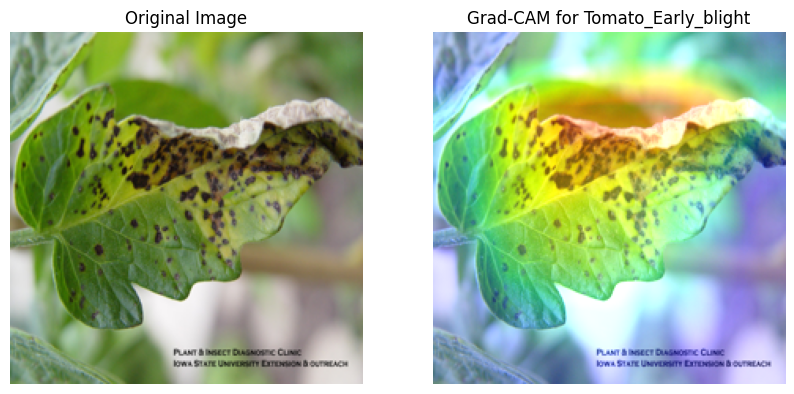

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import cv2  # For resizing the CAM

# Define a function to apply Grad-CAM
def grad_cam(image_path, model, target_layer, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Preprocess and add batch dimension

    # Forward hook to extract the target layer's features
    activations = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Register the hook
    hook = target_layer.register_forward_hook(forward_hook)

    # Make the prediction
    model.eval()
    outputs = model(input_tensor)  # Forward pass without no_grad
    predicted_class_idx = outputs.argmax(dim=1).item()

    # Backward pass to calculate gradients
    model.zero_grad()
    one_hot = torch.zeros(outputs.shape, dtype=torch.float).to(device)
    one_hot[0, predicted_class_idx] = 1
    outputs.backward(gradient=one_hot, retain_graph=True)

    # Get gradients of the target layer
    gradients = target_layer.weight.grad.cpu().data.numpy()

    # Get weights by averaging gradients over width and height
    weights = np.mean(gradients, axis=(2, 3))
    activations = activations[0].cpu().data.numpy()  # Convert activations to NumPy
    cam = np.zeros(activations.shape[1:], dtype=np.float32)  # Initialize CAM

    # Multiply each channel of activations by its corresponding weight
    for i, w in enumerate(weights[0]):
        cam += w * activations[i]

    # Normalize CAM
    cam = np.maximum(cam, 0)  # ReLU operation
    cam = cam / np.max(cam)  # Normalize to [0, 1]

    # Resize CAM to match input image size
    cam = cv2.resize(cam, (224, 224))  # Resize to original image size

    # Convert image to numpy array for visualization
    img_array = np.asarray(image.resize((224, 224)))

    # Overlay CAM on the image
    heatmap = plt.cm.jet(cam)[..., :3]  # Create heatmap
    overlayed_image = heatmap * 0.4 + img_array / 255.0  # Blend heatmap with image

    # Plot the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image)
    plt.title(f"Grad-CAM for {class_names[predicted_class_idx]}")
    plt.axis("off")
    plt.show()

    # Remove the hook
    hook.remove()

# Example usage
target_layer = model.layer4[1].conv2  # Specify the target layer (e.g., last convolutional layer)
grad_cam(image_path="slst.jpg", model=model, target_layer=target_layer, class_names=class_names)
